In [1]:
# %%
import numpy as np
from tqdm import tqdm
import copy
import torch
from data import get_school_data

from ugnn.networks import Dynamic_Network, Unfolded_Network
from ugnn.utils.masks import non_zero_degree_mask, mask_split, pad_unfolded_mask
from ugnn.gnns import GCN, train, valid
from ugnn.conformal import get_prediction_sets

### Load data

In [2]:
# %%
As, node_labels, all_labels = get_school_data(return_all_labels=True)
T = len(As)
n = As[0].shape[0]
num_classes = len(np.unique(node_labels))

# Convert to a torch geometric dataset containing T graphs
dyn_network = Dynamic_Network(As, node_labels)

# Unfold the T graphs into a single graph
unf_network = Unfolded_Network(dyn_network)[0]


Number of time windows: 18
Number of nodes: 242


### Set up masks for the specified regime

In [3]:
# %%
# See https://arxiv.org/abs/2405.19230 for details on different regimes
regime = "temporal transductive"
data_mask = non_zero_degree_mask(As, n, T)
train_mask, valid_mask, calib_mask, test_mask = mask_split(
    data_mask, split_props=[0.2, 0.1, 0.35, 0.35], regime=regime
)

# Pad masks to include anchor nodes (required when unfolding)
train_mask = pad_unfolded_mask(train_mask, n)
valid_mask = pad_unfolded_mask(valid_mask, n)
calib_mask = pad_unfolded_mask(calib_mask, n)
test_mask = pad_unfolded_mask(test_mask, n)


### Train a UGCN

In [4]:
# %%
model = GCN(
    num_nodes=unf_network.num_nodes, num_channels=16, num_classes=num_classes, seed=123
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

max_valid_acc = 0
for epoch in tqdm(range(200)):
    _ = train(model, unf_network, train_mask, optimizer)
    valid_acc = valid(model, unf_network, valid_mask)

    if valid_acc > max_valid_acc:
        max_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

test_acc = valid(model, unf_network, test_mask)
print(f"Test accuracy: {test_acc:0.3f}")


100%|██████████| 200/200 [00:27<00:00,  7.40it/s]


Test accuracy: 0.893


### Compute conformal prediction sets

First, let's use the Adaptive Prediction Sets (APS) method to compute conformal prediction sets. 

In [5]:
# %%
output = best_model(unf_network.x, unf_network.edge_index, unf_network.edge_weight)
all_pred_sets = get_prediction_sets(
    output, unf_network, calib_mask, test_mask, score_function="APS", alpha=0.1
)

for calib_node_idx in np.random.randint(len(all_pred_sets), size=10):
    node_pred_set = all_pred_sets[calib_node_idx]
    node_idx = np.where(calib_mask == 1)[0][calib_node_idx]

    # Convert predictions to label names
    possible_labels_for_node = [
        str(all_labels[pred]) for pred in np.where(node_pred_set == 1)[0]
    ]
    print(
        f"Node {node_idx} (True label {str(all_labels[unf_network.y[node_idx]])}): {possible_labels_for_node}"
    )

Node 4352 (True label Teachers): ['1A', '1B', '2A', '2B', '3A']
Node 3657 (True label 1B): ['1A']
Node 4162 (True label 2A): ['1B', '2A', '2B']
Node 3492 (True label 3A): ['1A', '1B', '2A', '3A', '3B']
Node 3675 (True label 1B): ['1A', '1B', '2A']
Node 3095 (True label 5A): ['4A', '4B', '5B']
Node 3097 (True label 5A): ['4A', '5A']
Node 3704 (True label 2B): ['1A', '2A', '2B', '3A']
Node 2941 (True label 1B): ['1A', '1B', '4A']
Node 3704 (True label 2B): ['1A', '2A', '2B', '3A']


### Visualise the UGCN Embedding

The embedding is 11-dimensional, due to there being 11 classes in this data.

Let's visualise the embedding by reducing to 2D using PCA.

In [6]:
from sklearn.decomposition import PCA
import pyemb as eb

# As we're unfolding, we get both an anchor and dynamic embedding
# Let's select the dynamic embedding
emb = output.detach()[n:]

# Reduce to 2D
emb = PCA(n_components=2).fit_transform(emb)

In [7]:
# Animated plot
spatial_node_labels = node_labels[0:n]
anim_fig = eb.quick_plot(emb, n, T, node_labels=spatial_node_labels)

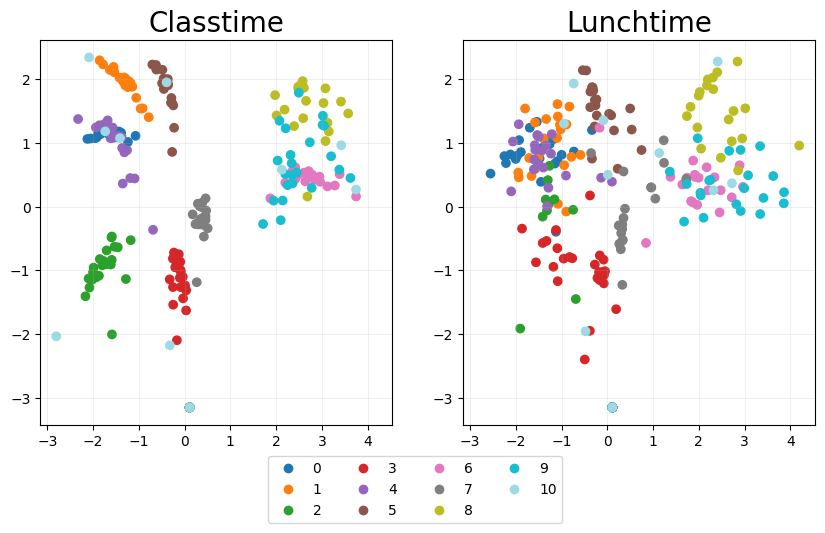

In [8]:
# Plot specific snapshots 

# Select snapshots to be shown
points_of_interest = [0, 5]
point_labels = ["Classtime", "Lunchtime"]

# Plot the snapshots
snap_fig = eb.snapshot_plot(
    emb.reshape(T, n, 2),
    node_labels = spatial_node_labels,
    idx_of_interest = points_of_interest,
    title=point_labels,
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True,
    cmap="tab20"
)